<a href="https://colab.research.google.com/github/simsoohyeon/2023-A-DA/blob/main/%EC%8B%A4%EC%8A%B5_%EC%BD%94%EB%93%9C_%ED%8C%8C%EC%9D%BC_20232877_%EC%8B%AC%EC%88%98%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**새로 확장한 모델은 아래 셀에 있습니다**
#**아래에서 확인해주시면 감사하겠습니다**
코랩에서 확장 모델 만들다가 런타임에 도달하고, 세션이 자꾸 종료되어 기본 U-Net 모델이 학습이 되지 않는 오류가 계속 발생했습니다. 한 파일에 두 모델(기본 모델과 확장 모델)이 있어야 했는데 확장 모델을 만드는 도중 빈번하게 세션/런타임에 도달하여 이렇게 성능이 좋지 않은 모델을 제작하게 되었습니다. 참고해주시면 감사하겠습니다. 확장 모델은 제대로 학습이 되었기 때문에 제가 제작한 확장 모델 위주로 보고서 작성했습니다.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

path_to_annotation="/content/drive/MyDrive/annotations/trimaps"

path_to_image="/content/drive/MyDrive/images"

images=sorted(glob.glob(path_to_image+"/*.jpg"))

for i in images:
  img=Image.open(i)
  img=np.array(img)
  if img.shape[-1]!=3:
    filename=i.split('/')[-1].split(".")[0]
    gt_filename=filename+".png"

    os.remove(os.path.join(path_to_annotation,gt_filename))
    os.remove(i)

    annotation=Image.open(path_to_annotation+"/Abyssinian_1.png")
    plt.subplot(1,2,1)
    plt.title("annotation")
    plt.imshow(annotation)

    image=Image.open(path_to_image+"/Abyssinian_1.jpg")
    plt.subplot(1,2,2)
    plt.title("image")
    plt.imshow(image)

    plt.show()



In [ ]:
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
import glob
import numpy as np

class Pets(Dataset):
  def __init__(self, path_to_img, path_to_anno, train=True, transforms=None, input_size=(128,128)):
    """
    사용자 정의 데이터셋 클래스
    path_to_img
    path_to_anno
    train
    transforms
    input_size
    """

    #
    self.images = sorted(glob.glob(path_to_img + "/*.jpg"))
    self.annotations = sorted(glob.glob(path_to_anno + "/*.png"))

    # 데이터셋을 학습과 평가용으로 나눔 8:2
    self.X_train = self.images[:int(0.8 * len(self.images))]
    self.X_test = self.images[int(0.8 * len(self.images)):]
    self.Y_train = self.annotations[:int(0.8 * len(self.annotations))]
    self.Y_test = self.annotations[int(0.8 * len(self.annotations)):]

    # 학습 여부, transform, input size 저장
    self.train = train
    self.transforms = transforms
    self.input_size = input_size

  def __len__(self):
    if self.train:
      return len(self.X_train)
    else:
      return len(self.X_test)

     # 마스크 이미지 전처리 함수

    '''
    마스크 이미지 전처리 함수
    '''

  def preprocess_mask(self, mask):  # ✅ 오타 수정됨
    mask = mask.resize(self.input_size)
    mask = np.array(mask).astype(np.float32)
    mask[mask != 2.0] = 1.0
    mask[mask == 2.0] = 0.0
    mask = torch.tensor(mask)
    return mask

  def __getitem__(self, i):
    if self.train:
      X_train = Image.open(self.X_train[i])
      X_train = self.transforms(X_train)
      Y_train = Image.open(self.Y_train[i])
      Y_train = self.preprocess_mask(Y_train)  # ✅ 여기도 오타 수정됨

      return X_train, Y_train

    else:
      X_test = Image.open(self.X_test[i])
      X_test = self.transforms(X_test)
      Y_test = Image.open(self.Y_test[i])
      Y_test = self.preprocess_mask(Y_test)  # ✅ 오타 수정

      return X_test, Y_test


In [ ]:
import torch.nn as nn

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    #인코더 Contracting Path
    #특징 추출하는 conv2d 2개 + Maxpolling으로 다운 샘플링(해상도 감소, 채널 증가)

    #인코더 레벨1
    self.enc1_1=nn.Conv2d(3,64,kernel_size=3,padding=1)
    self.enc1_2=nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.pool1=nn.MaxPool2d(kernel_size=2,stride=2)

    #인코더 레벨2
    self.enc2_1=nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.enc2_2=nn.Conv2d(128,128,kernel_size=3,padding=1)
    self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)

    #인코더 레벨3
    self.enc3_1=nn.Conv2d(128,256,kernel_size=3,padding=1)
    self.enc3_2=nn.Conv2d(256,256,kernel_size=3,padding=1) #### 수정
    self.pool3=nn.MaxPool2d(kernel_size=2,stride=2)

    #인코더 레벨4
    self.enc4_1=nn.Conv2d(256,512,kernel_size=3,padding=1)
    self.enc4_2=nn.Conv2d(512,512,kernel_size=3,padding=1)
    self.pool4=nn.MaxPool2d(kernel_size=2,stride=2)

    #가장 깊은 곳의 특징을 표현하는 부분
    self.enc5_1=nn.Conv2d(512,1024,kernel_size=3,padding=1)
    self.enc5_2=nn.Conv2d(1024,512,kernel_size=3,padding=1)

    #디코더 expanding path
    #업샘플링->skip connection과 연결 concatenation->Conv2d

    #디코더 레벨4
    self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
    self.dec4_1=nn.Conv2d(1024,512,kernel_size=3,padding=1)
    self.dec4_2=nn.Conv2d(512,256,kernel_size=3,padding=1)

    #디코더 레벨3
    self.upsample3=nn.ConvTranspose2d(256,256,2,stride=2)
    self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
    self.dec3_2=nn.Conv2d(256,128,kernel_size=3,padding=1)

    #디코더 레벨2
    self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
    self.dec2_1=nn.Conv2d(256,128,kernel_size=3,padding=1)
    self.dec2_2=nn.Conv2d(128,64,kernel_size=3,padding=1)

    #디코더 레벨1
    self.upsample1=nn.ConvTranspose2d(64,64,2,stride=2)
    self.dec1_1=nn.Conv2d(128,64,kernel_size=3,padding=1)
    self.dec1_2=nn.Conv2d(64,1,kernel_size=1)

    #사용할 활성화 함수 정의
    self.relu=nn.ReLU()
    self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    #인코더:특징 추출, 다운샘플링
    x=self.enc1_1(x)
    x=self.relu(x)
    e1=self.enc1_2(x)
    e1=self.relu(e1)
    x=self.pool1(e1)

    x=self.enc2_1(x)
    x=self.relu(x)
    e2=self.enc2_2(x)
    e2=self.relu(e2)
    x=self.pool2(e2)

    x=self.enc3_1(x)
    x=self.relu(x)
    e3=self.enc3_2(x)
    e3=self.relu(e3)
    x=self.pool3(e3)

    x=self.enc4_1(x)
    x=self.relu(x)
    e4=self.enc4_2(x)
    e4=self.relu(e4)
    x=self.pool4(e4)

    x=self.enc5_1(x)
    x=self.relu(x)
    x=self.enc5_2(x)
    x=self.relu(x)
    x=self.upsample4(x)

    #디코더:업샘플링+skip connection+복원
    x=torch.cat([x,e4],dim=1)
    x=self.dec4_1(x)
    x=self.relu(x)
    x=self.dec4_2(x)
    x=self.relu(x)

    x=self.upsample3(x)
    x=torch.cat([x,e3],dim=1)
    x=self.dec3_1(x)
    x=self.relu(x)
    x=self.dec3_2(x)
    x=self.relu(x)

    x=self.upsample2(x)
    x=torch.cat([x,e2],dim=1)
    x=self.dec2_1(x)
    x=self.relu(x)
    x=self.dec2_2(x)
    x=self.relu(x)

    x=self.upsample1(x)
    x=torch.cat([x,e1],dim=1)
    x=self.dec1_1(x)
    x=self.relu(x)
    x=self.dec1_2(x)
    x=self.relu(x)
    #x=self.dec1_3(x) #최종출력

    x=torch.squeeze(x) # 흑백 이미지를 그리기 위해 채널을 없앰 #### 제거
    # 채널 차원을 제거하였음 (batch,1,h,w)->(batch,h,w)

    return x

In [ ]:
import tqdm

#데이터 전처리 도구
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor,Resize

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device="cuda" if torch.cuda.is_available() else "cpu"

#입력 이미지에 적용할 전처리 파이프라인을 적용
#이미지 크기를 (128,128)로 조정하는 것
transform=Compose([Resize((128,128)),ToTensor()])

#**데이터 불러오기**

In [ ]:
#학습 데이터 생성
#transform적용
train_set=Pets(path_to_img=path_to_image,path_to_anno=path_to_annotation,transforms=transform)

#평가용 데이터 생성
#transform적용
test_set=Pets(path_to_img=path_to_image, path_to_anno=path_to_annotation,transforms=transform, train=False) #평가용

#학습용 데이터로더
#32개씩 배치단위로 데이터를 불러오고, 매 에포크마다 데이터순서를 섞음 shuffle=True
train_loader=DataLoader(train_set, batch_size=32, shuffle=True)

#평가용 데이터로더(셔플할 필요가 없음, 셔플 안하는 것이 기본값이라 생략)
test_loader=DataLoader(test_set)

In [ ]:
# 모델 정의
model=UNet().to(device)

#학습률 정의
learning_rate=0.0001

#최적화 정의
optim=Adam(params=model.parameters(),lr=learning_rate)

In [ ]:
#p.20
for epoch in range(5):
  iterator = tqdm.tqdm(train_loader)

  #배치단위로 반복
  for data, label in iterator:
    optim.zero_grad()  # 이전 루프의 기울기 초기화

    preds = model(data.to(device))  # ✅ OK

    # BCE With Logits Loss
    # BCE: Binary Cross Entropy + Sigmoid 내부 포함됨
    # label을 float으로 변환 후 GPU로 이동함
    # BCEWithLogitsLoss에서 요구하는 입력과 정답 타입이 모두 float여야 하기 때문
    # 변화없이 정수로 구현하면 오류 발생
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(preds, label.type(torch.FloatTensor).to(device))  # ← 들여쓰기 수정

    loss.backward()  # 오차 역전파
    optim.step()     # 최적화 (파라미터 업데이트)

    iterator.set_description(f"epoch {epoch+1} loss: {loss.item():.4f}")  # 진행 상태 출력

  torch.save(model.state_dict(), "./UNet.pth")  # 에폭 단위로 모델 저장


epoch 1 loss: 0.6931:   2%|▏         | 4/185 [04:41<3:37:16, 72.03s/it]

<ipython-input-23-099092de464b>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./UNet.pth", map_location=device))  # 모델 구조와 파일 매칭 주의!


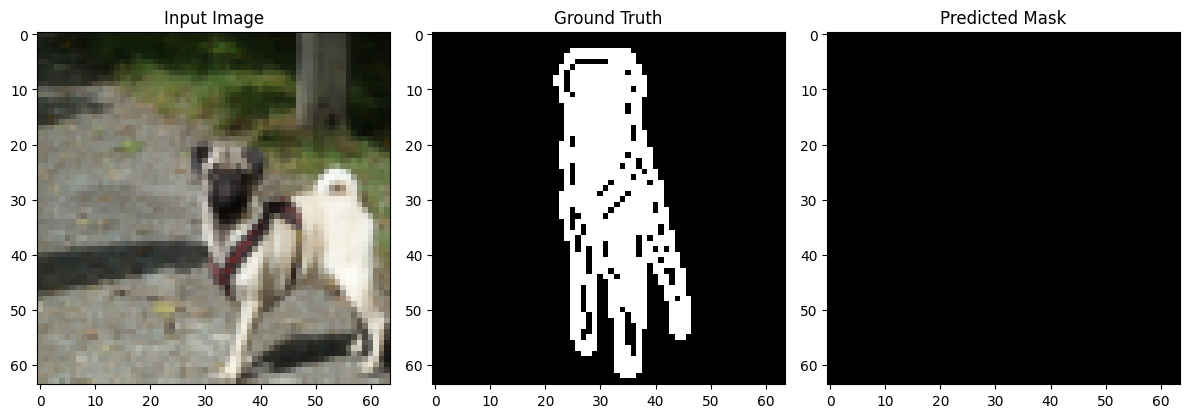

In [ ]:
import torch
import matplotlib.pyplot as plt

# ✅ 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ 모델 정의 및 로딩
model = UNet()  # 또는 DeepUNet()
model.load_state_dict(torch.load("./UNet.pth", map_location=device))  # 모델 구조와 파일 매칭 주의!
model.to(device)
model.eval()

# ✅ 테스트 데이터셋에서 샘플 하나 불러오기
data, label = test_set[1]  # 예: test_set[1]
data = data.to(device)     # 모델과 동일한 디바이스로 이동

# ✅ 예측 수행 (sigmoid 적용 + threshold 0.5)
with torch.no_grad():
    output = model(torch.unsqueeze(data, dim=0))        # (1, C, H, W)
    prob = torch.sigmoid(output)                        # 0~1 확률값으로 변환
    pred = prob > 0.5                                   # 이진 마스크 생성

# ✅ 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(data.cpu().permute(1, 2, 0))  # (C,H,W) → (H,W,C)

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(label, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred.cpu().squeeze(), cmap="gray")

plt.tight_layout()
plt.show()


#**생각해보기**
1. encoder-decoder 구조란 무엇인가?

2. U-Net의 encoder 층이 10층이라면, 디코더 층은 몇 층이어야 하는가?

3. U-Net의 Encoder-Decoder 구조에서 skip connection의 역할은 무엇인가?

4. (추가활동) BCEWithLogitsLoss에 대해 조사하

#**확장한 모델 여기서부터입니다**
코랩에서 확장 모델 만들다가 런타임에 도달하고, 세션이 자꾸 종료되어 기본 U-Net 모델이 학습이 되지 않는 오류가 계속 발생했습니다. 한 파일에 두 모델(기본 모델과 확장 모델)이 있어야 했는데 확장 모델을 만드는 도중 빈번하게 세션/런타임에 도달하여 이렇게 성능이 좋지 않은 모델을 제작하게 되었습니다. 참고해주시면 감사하겠습니다. 확장 모델은 제대로 학습이 되었기 때문에 제가 제작한 확장 모델 위주로 보고서 작성했습니다.

#**과제_DeepUNet 모델 만들기**

##**Pets Dataset 클래스 정의**

In [ ]:
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
import glob
import numpy as np

class Pets(Dataset):
    def __init__(self, path_to_img, path_to_anno, train=True, transforms=None, input_size=(64, 64)):
        self.images = sorted(glob.glob(path_to_img + "/*.jpg"))
        self.annotations = sorted(glob.glob(path_to_anno + "/*.png"))
        self.X_train = self.images[:int(0.8 * len(self.images))]
        self.X_test = self.images[int(0.8 * len(self.images)):]
        self.Y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.Y_test = self.annotations[int(0.8 * len(self.annotations)):]
        self.train = train
        self.transforms = transforms
        self.input_size = input_size

    def __len__(self):
        return len(self.X_train) if self.train else len(self.X_test)

    def preprocess_mask(self, mask):
        mask = mask.resize(self.input_size)
        mask = np.array(mask).astype(np.float32)
        mask[mask != 2.0] = 1.0
        mask[mask == 2.0] = 0.0
        return torch.tensor(mask)

    def __getitem__(self, i):
        X = Image.open(self.X_train[i] if self.train else self.X_test[i])
        Y = Image.open(self.Y_train[i] if self.train else self.Y_test[i])
        if self.transforms:
            X = self.transforms(X)
        Y = self.preprocess_mask(Y)
        return X, Y


##**깊게 확장된 U-Net 모델 (5단계 인코더/디코더)**

In [ ]:
import torch
import torch.nn as nn

class DeepUNet(nn.Module):
    def __init__(self):
        super(DeepUNet, self).__init__()

        # 인코더 7단계
        self.enc1 = self.block(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = self.block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = self.block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = self.block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.enc5 = self.block(512, 1024)
        self.pool5 = nn.MaxPool2d(2)

        self.enc6 = self.block(1024, 2048)
        self.pool6 = nn.MaxPool2d(2)

        self.enc7 = self.block(2048, 4096)

        # 디코더 7단계
        self.up6 = nn.ConvTranspose2d(4096, 2048, kernel_size=2, stride=2)
        self.dec6 = self.block(4096, 2048)

        self.up5 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.dec5 = self.block(2048, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        e5 = self.enc5(self.pool4(e4))
        e6 = self.enc6(self.pool5(e5))
        e7 = self.enc7(self.pool6(e6))

        d6 = self.up6(e7)
        d6 = self.dec6(torch.cat([d6, e6], dim=1))

        d5 = self.up5(d6)
        d5 = self.dec5(torch.cat([d5, e5], dim=1))

        d4 = self.up4(d5)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final(d1)


##**transform 정의 (RandomHorizontalFlip + Resize)**

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip

transform = Compose([
    Resize((64, 64)),
    RandomHorizontalFlip(),
    ToTensor()
])

##**데이터셋 로딩**

In [ ]:
from torch.utils.data import DataLoader

train_set = Pets(path_to_img=path_to_image, path_to_anno=path_to_annotation, transforms=transform)
test_set = Pets(path_to_img=path_to_image, path_to_anno=path_to_annotation, transforms=transform, train=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

##**모델 및 옵티마이저 정의**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DeepUNet().to(device)

from torch.optim import Adam
import torch.nn as nn

learning_rate = 0.0001
optimizer = Adam(model.parameters(), lr=learning_rate)

##**학습코드 epoch=5**

In [ ]:
import tqdm

loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(5):
    model.train()
    loop = tqdm.tqdm(train_loader)
    for x, y in loop:
        x, y = x.to(device), y.unsqueeze(1).to(device).float()

        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch+1}/5]")
        loop.set_postfix(loss=loss.item())

    torch.save(model.state_dict(), "./DeepUNet.pth")

Epoch [5/5]: 100%|██████████| 185/185 [01:19<00:00,  2.31it/s, loss=0.569]


##**예측 및 시각화**

<ipython-input-20-3e4184406646>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./DeepUNet.pth", map_location=device))


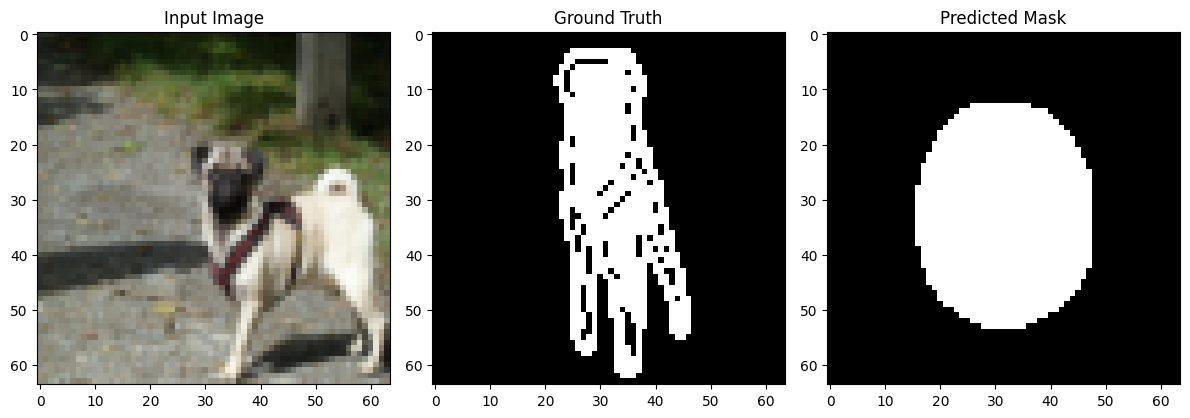

In [ ]:
import torch
import matplotlib.pyplot as plt

# ✅ 디바이스 설정 (GPU가 가능하면 GPU, 아니면 CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ 모델 로드 및 디바이스 이동
model = DeepUNet()  # 또는 UNet()으로 변경 가능
model.load_state_dict(torch.load("./DeepUNet.pth", map_location=device))
model.to(device)
model.eval()

# ✅ 테스트 이미지 하나 불러오기
data, label = test_set[1]  # 동일한 인덱스로 비교 가능
data = data.to(device)     # 🔥 모델과 동일 디바이스로 이동

# ✅ 예측 수행
with torch.no_grad():
    pred = model(torch.unsqueeze(data, dim=0)) > 0.5  # 배치 차원 추가 + 이진 분류

# ✅ 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(data.cpu().permute(1, 2, 0))  # (C,H,W) → (H,W,C)

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(label, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred.cpu().squeeze(), cmap="gray")

plt.tight_layout()
plt.show()

<ipython-input-21-c2c673d80b96>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load("./UNet.pth", map_location=device))
<ipython-input-21-c2c673

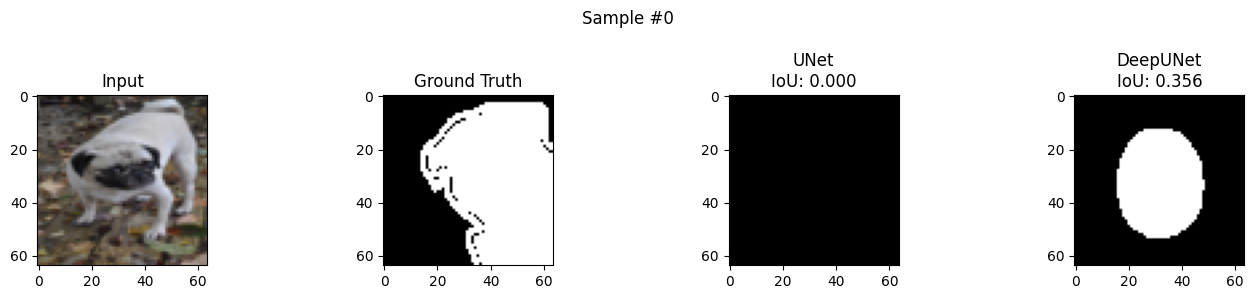

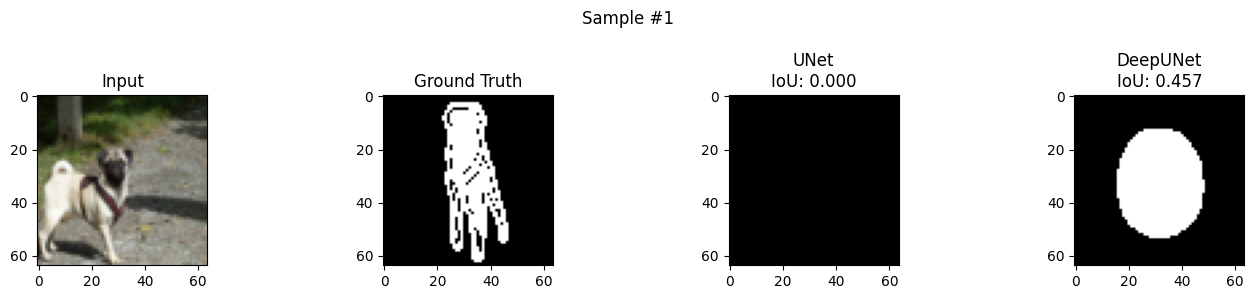

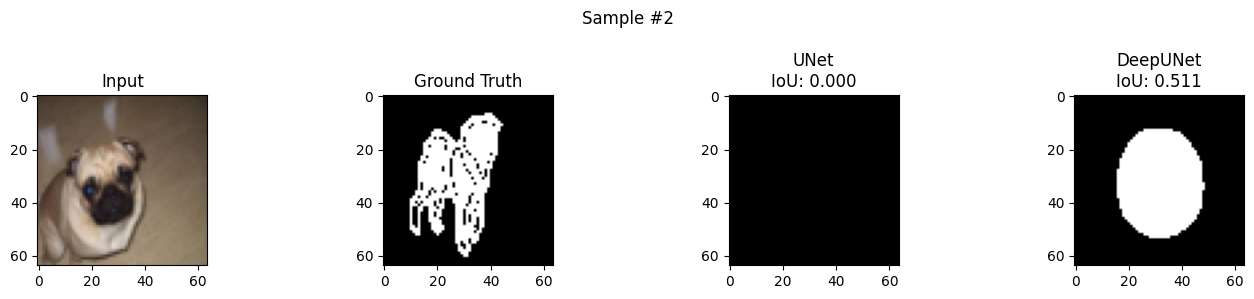

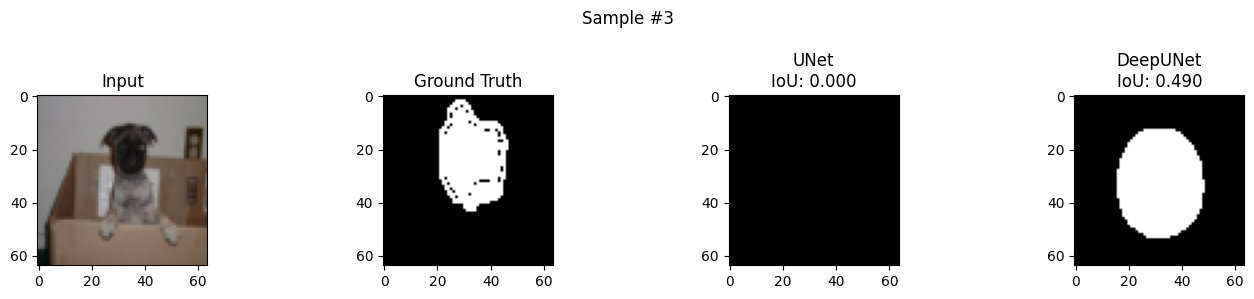

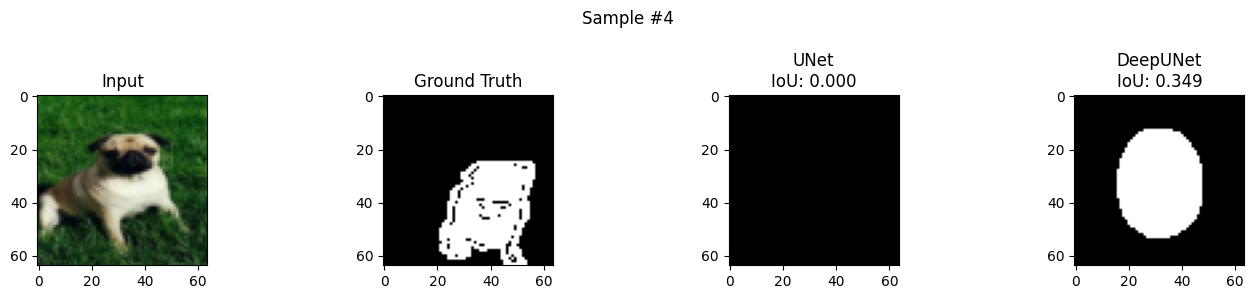

In [ ]:
import torch
import matplotlib.pyplot as plt

# ✅ 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ 모델 로딩
unet = UNet().to(device)
unet.load_state_dict(torch.load("./UNet.pth", map_location=device))
unet.eval()

deepunet = DeepUNet().to(device)
deepunet.load_state_dict(torch.load("./DeepUNet.pth", map_location=device))
deepunet.eval()

# ✅ 성능 지표: IoU 계산 함수
def compute_iou(pred, target):
    pred = pred.byte()
    target = target.byte()
    intersection = (pred & target).float().sum()
    union = (pred | target).float().sum()
    return (intersection / union).item() if union > 0 else 0.0

# ✅ 이미지 5장 비교
indices = [0, 1, 2, 3, 4]  # 원하는 5개 인덱스
for idx in indices:
    data, label = test_set[idx]
    data = data.to(device)
    label_bin = label.byte()

    with torch.no_grad():
        pred_unet = unet(torch.unsqueeze(data, dim=0)).squeeze() > 0.5
        pred_deep = deepunet(torch.unsqueeze(data, dim=0)).squeeze() > 0.5

    iou_unet = compute_iou(pred_unet.cpu(), label_bin)
    iou_deep = compute_iou(pred_deep.cpu(), label_bin)

    # ✅ 시각화
    plt.figure(figsize=(14, 3))
    plt.subplot(1, 4, 1)
    plt.title("Input")
    plt.imshow(data.cpu().permute(1, 2, 0))

    plt.subplot(1, 4, 2)
    plt.title("Ground Truth")
    plt.imshow(label, cmap="gray")

    plt.subplot(1, 4, 3)
    plt.title(f"UNet\nIoU: {iou_unet:.3f}")
    plt.imshow(pred_unet.cpu(), cmap="gray")

    plt.subplot(1, 4, 4)
    plt.title(f"DeepUNet\nIoU: {iou_deep:.3f}")
    plt.imshow(pred_deep.cpu(), cmap="gray")

    plt.suptitle(f"Sample #{idx}")
    plt.tight_layout()
    plt.show()